# Learning and Decision Making

## Laboratory 4: Supervised learning

In the end of the lab, you should submit all code/answers written in the tasks marked as "Activity n. XXX", together with the corresponding outputs and any replies to specific questions posed to the e-mail <adi.tecnico@gmail.com>. Make sure that the subject is of the form [&lt;group n.&gt;] LAB &lt;lab n.&gt;.

In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

### 1. The LFW dataset

The LFW (Labeled Faces in the Wild) data set is a collection of JPEG pictures of famous people collected over the internet. Each picture is centered on a single face and corresponds to a grayscale image of 62 $\times$ 47 pixels. 

---

We start by loading the dataset, selecting only those people in the dataset that appear in at least 50 pictures.

<IPython.core.display.Javascript object>


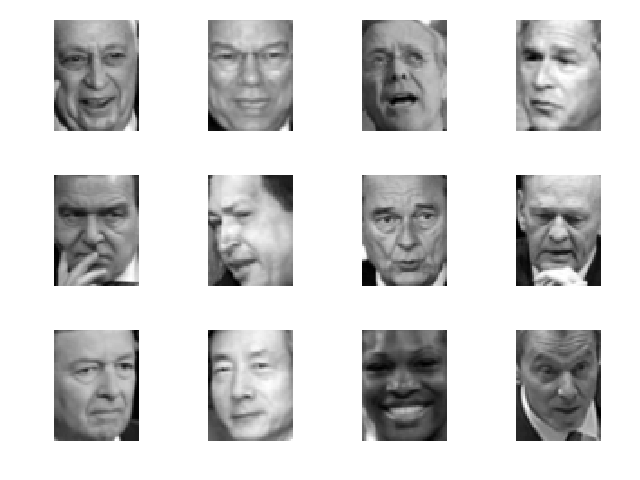

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn import datasets

# Load dataset
lfw = datasets.fetch_lfw_people(min_faces_per_person=50)

fig = plt.figure()

# Print sample digits
for i in range(12): 
    plt.subplot(3, 4, i + 1)
    idx=list(lfw.target).index(i)
    plt.imshow(lfw.images[idx], cmap=plt.cm.gray)
    plt.axis('off')

fig.tight_layout()
plt.show()

In the first activities, you will prepare the dataset, before running the learning algorithm.

---

#### Activity 1.        

From the LFW dataset, construct the training and test sets. The input data can be accessed as the attribute `data` in the dataset `lfw`; the corresponding output data can be accessed as the attribute `target` in `lfw`. To build the train and test sets, you can use the function `train_test_split` from the module `model_selection` of `scikit-learn`. Make sure that the test set corresponds to 10% of your data. 

**Note:** Don't forget to import `numpy` and the necessary modules from `scikit-learn`. Also, for reproducibility, initialize the seed of the `train_test_split` function to a fixed number.

---

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

Input = lfw.data
Output = lfw.target

print("Size of input = %d" % Input.size)
print("Size of output = %d" % Output.size)

In_train, In_test, Out_train, Out_test = train_test_split(Input, Output, test_size = 0.1, random_state = 42)

print("Size of Train Input = %d" % In_train.size)
print("Size of Test Input = %d" % In_test.size)
print("Size of Train output = %d" % Out_train.size)
print("Size of Test output = %d" % Out_test.size)

print("Input Train = \n %s \n" % In_train)
print("Input Test = \n %s \n" % In_test)
print("Output Train = \n %s \n" % Out_train)
print("Output Test = \n %s \n" % Out_test)

Size of input = 4545840
Size of output = 1560
Size of Train Input = 4091256
Size of Test Input = 454584
Size of Train output = 1404
Size of Test output = 156
Input Train = 
 [[  63.           71.           77.33333588 ...,   16.33333397   15.           14.        ]
 [  53.66666794   67.33333588   86.         ...,   31.33333397   28.
    30.33333397]
 [  73.66666412   64.66666412   69.         ...,  208.33332825
   174.33332825   93.33333588]
 ..., 
 [ 162.33332825  162.33332825  133.         ...,   55.           56.
    55.33333206]
 [ 150.          143.          120.         ...,   22.33333397   36.
    82.66666412]
 [ 126.          131.33332825  138.66667175 ...,  171.66667175
   190.66667175  191.33332825]] 

Input Test = 
 [[ 105.66666412  105.66666412  103.66666412 ...,    8.33333302
     7.33333349    7.33333349]
 [ 141.          149.66667175  159.         ...,  181.33332825  117.           52.        ]
 [  60.           63.66666794   67.66666412 ...,   23.33333397
    22.3333339

Right now, each point in the dataset is represented by the pixel information, which roughly corresponds to 3,000 features. In this activity, you will determine a small number of alternative features that manage to capture most of the relevant information contained in each picture but which provide a much more compact representation thereto. Such features correspond to the _principal components_ and can be computed through the function `PCA`, in the `decomposition` module of `scikit-learn`. 

---

#### Activity 2.        

* Run PCA on the training set. To do this, you should first fit the PCA model to the data and then use the resulting model to transform the data. For details, check the documentation for the function `PCA`.

* To grasp how much of the information in the data is contained in the different components, plot the _cumulative explained variance_ (in percentage) as a function of the number of components. The explained variance can be accessed via the attribute `explained_variance_` of your model.

**Note:** In general, before running PCA on some training set, you should _normalize_ the data to make sure that all inputs lie in the same range. In our case, since all pixels lie in the same range, normalization is not necessary.

---

<IPython.core.display.Javascript object>


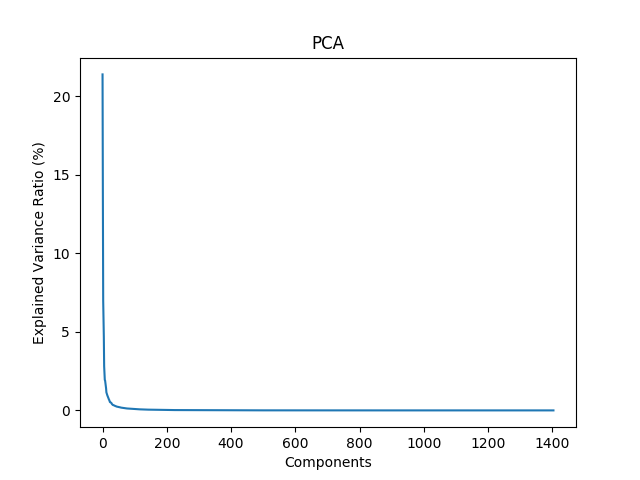

<IPython.core.display.Javascript object>


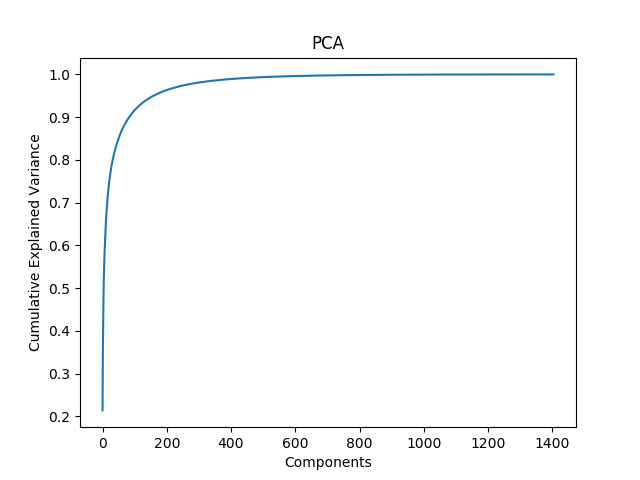

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA()

pca.fit_transform( In_train )

v = pca.explained_variance_ratio_
v2 = np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_)

#print(v)


%matplotlib notebook
plt.figure()
plt.plot(v * 100)
plt.title("PCA")
plt.xlabel("Components")
plt.ylabel("Explained Variance Ratio (%)")
plt.show()

fig = plt.figure()
plt.plot(v2)
plt.title("PCA")
plt.xlabel("Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

Note how 50 components explain almost 90\% of the variance in the data. As such, it seems reasonable that we may rely only on those 50 components as features to represent our data. 

However, to clearly understand the implications of the adopted representation, you will now run an extensive test to investigate how the number of components may impact the performance of the classifier. 

---

#### Activity 3.        

Take the data in your training set and further split it in two sets, $D_T$ and $D_V$, where $D_T$ corresponds to $85\%$ of the training data and $D_V$ to the remaining $15\%$. You will use $D_T$ for training, and $D_V$ for validation. 

For $k\in\{10, 20, ..., 100\}$,

* Run PCA with $k$ components on the data in $D_T$
* Transform the data in $D_T$ using the computed PCA
* Train a logistic regression classifier on the transformed data, with $C=1000$
* Compute the error in $D_T$ and in $D_V$

Repeat the _whole process_ (including the split of $D_T$ and $D_V$) 30 times.

** Note: ** The whole process may take a while, so don't despair. The logistic classifier can be accessed by importing `LogisticRegression` from `sklearn.linear_model`. To compute the error of a classifier, you can use the `accuracy_score` function from `sklearn.metrics`.

---

In [12]:

def algorithm(c):
    accuraciesT = []
    accuraciesV = []
    logistic = linear_model.LogisticRegression(C = c)

    for i in range(0, 30):
        xDt, xDv, yDt, yDv = train_test_split(In_train, Out_train, train_size = 0.85)

        for k in range(1, 11):

            #Find important components
            pca = PCA(n_components = 10*k).fit(xDt)
            xt = pca.transform(xDt)
            xv = pca.transform(xDv)
            #print(xt)

            #train LR
            logistic.fit(xt, yDt)

            #test LR
            yt = logistic.predict(xt)
            yv = logistic.predict(xv)

            actT = accuracy_score(yDt, yt)
            actV = accuracy_score(yDv, yv)
            #print(act)
            accuraciesT.append(actT)
            accuraciesV.append(actV)
    
    return accuraciesT, accuraciesV

In [13]:
accuraciesT, accuraciesV = algorithm(1000)
        
print("T: \n%s\n" % accuraciesT)
print("V: \n%s\n" % accuraciesV)

T: 
[0.43084660519698242, 0.63537300922045259, 0.75859178541492034, 0.8331936295054484, 0.86336965632858342, 0.89606035205364631, 0.92623637887678123, 0.94635373009220458, 0.95641240569991615, 0.96730930427493711, 0.42665549036043587, 0.62950544844928746, 0.76026823134953903, 0.81726739312657171, 0.865046102263202, 0.89522212908633692, 0.91701592623637884, 0.94970662196144173, 0.95557418273260686, 0.96311818943839056, 0.43839061190276613, 0.63118189438390615, 0.75943000838222963, 0.81559094719195302, 0.86672254819782057, 0.89941324392288347, 0.92791282481139981, 0.94551550712489518, 0.95808885163453483, 0.95976529756915341, 0.43839061190276613, 0.62866722548197818, 0.75691533948030176, 0.82648784576697398, 0.86336965632858342, 0.89019279128248119, 0.92875104777870909, 0.95222129086336971, 0.95725062866722543, 0.96395641240569996, 0.44258172673931268, 0.6429170159262364, 0.77200335289186928, 0.8340318524727578, 0.88432523051131606, 0.90360435875943002, 0.93461860854987422, 0.95976529756

---

#### Activity 4.        

Plot the average training and validation error from Activity 3 as a function of $k$. Comment.

---

In [17]:
train = accuraciesT
validation = accuraciesV

v = np.zeros( (10, len(accuraciesV)//10) )
t = np.zeros( (10, len(accuraciesT)//10) )

k = 0
for i in range(0, len(accuraciesT) // 10):
    for j in range(0, 10):
        v[j][i] = train[k]
        t[j][i] = validation[k]
        k+=1
    

<IPython.core.display.Javascript object>


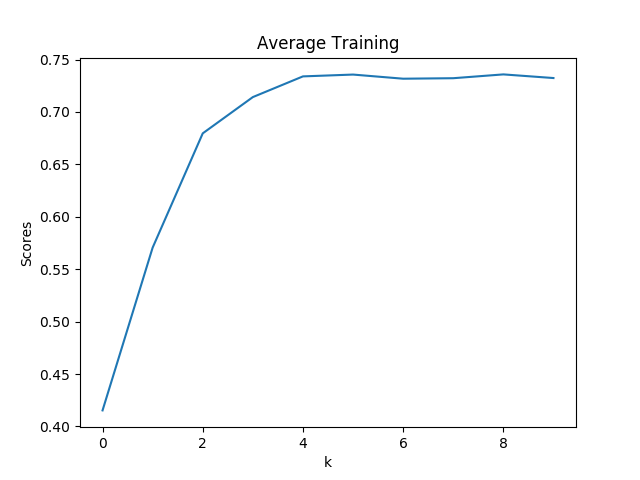

<IPython.core.display.Javascript object>


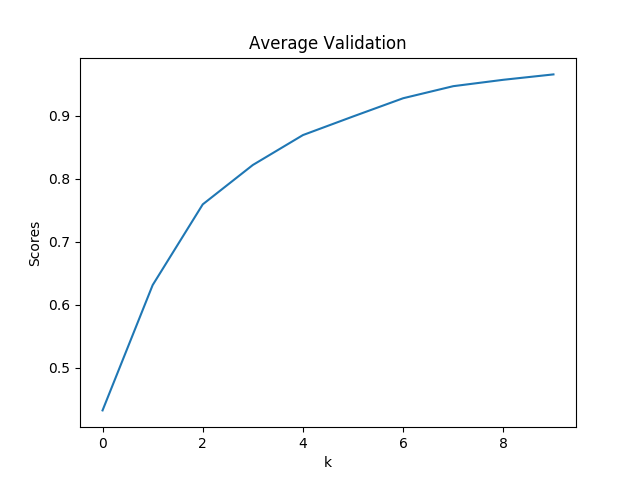

By observing the plots, we can conclude that the more components are studied the better the scores of both the train and tests.


In [18]:
averageT = np.zeros( (10, 1) )
averageV = np.zeros( (10, 1) )

for i in range(0, 10):
    averageT[i][0] = sum(t[i]) / len(t[i])
    averageV[i][0] = sum(v[i]) / len(v[i])


%matplotlib notebook
plt.figure()
plt.plot(averageT)
plt.title("Average Training")
plt.xlabel("k")
plt.ylabel("Scores")
plt.show()


plt.figure()
plt.plot(averageV)
plt.title("Average Validation")
plt.xlabel("k")
plt.ylabel("Scores")
plt.show()

print("By observing the plots, we can conclude that the more components are studied the better the scores of both the train and tests.")

As seen in the homework, the logistic regression model is trained to minimize the cost function

$$J(\pi)=-\frac{1}{N}\sum_{n=1}^N\log(\pi(a_n\mid x_n)).$$

However, the logistic regression model in `scikit-learn` uses a slightly different cost function; this modified cost function includes a term that penalizes large values for the parameters $\mathbf{w}$ and takes the general form

$$J(\pi)=\frac{1}{2}\|w\|^2-\frac{C}{N}\sum_{n=1}^N\log(\pi(a_n\mid x_n)).$$

The first term is called a _regularization term_ and the constant $C$ expresses how much we are willing to pay (in terms of errors in the training set) to have small parameter vectors. In activity 3 you used a large value for $C$, indicating the algorithm that errors in the training set should be minimized.

---

#### Activity 5.

Repeat Activity 3 but now setting $C=1$. Plot the results and comment.

---

In [21]:
T, V = algorithm(1)

<IPython.core.display.Javascript object>


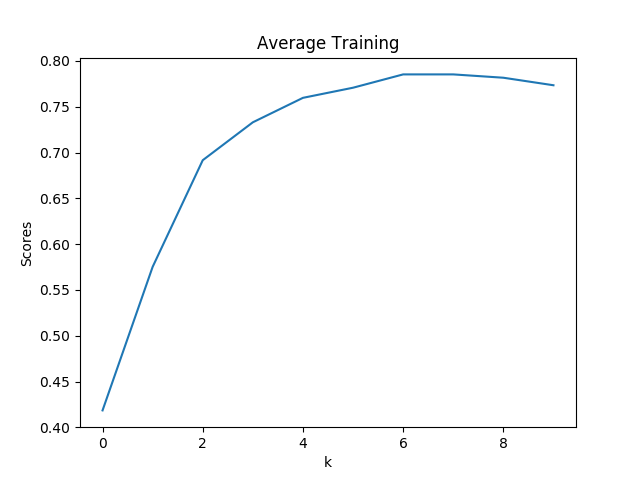

<IPython.core.display.Javascript object>


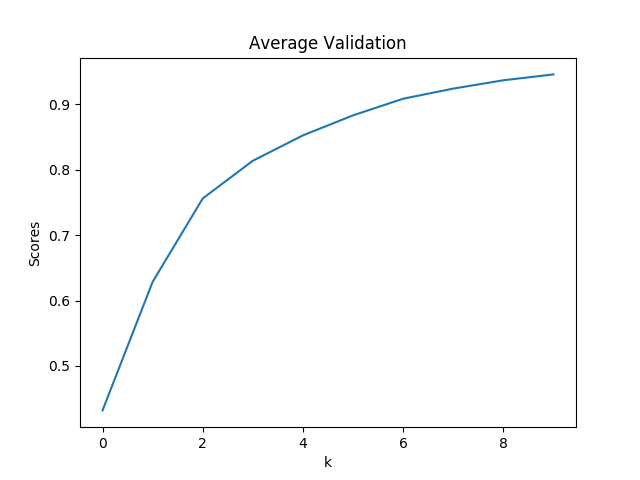

With C = 1, the average training reaches stable scores of around 80% starting from 60 components, with C = 1000, the results varied more after 60 components.


In [22]:
train = T
validation = V

v = np.zeros( (10, len(accuraciesV)//10) )
t = np.zeros( (10, len(accuraciesT)//10) )

k = 0
for i in range(0, len(accuraciesT) // 10):
    for j in range(0, 10):
        v[j][i] = train[k]
        t[j][i] = validation[k]
        k+=1
        
averageT = np.zeros( (10, 1) )
averageV = np.zeros( (10, 1) )

for i in range(0, 10):
    averageT[i][0] = sum(t[i]) / len(t[i])
    averageV[i][0] = sum(v[i]) / len(v[i])


%matplotlib notebook
plt.figure()
plt.plot(averageT)
plt.title("Average Training")
plt.xlabel("k")
plt.ylabel("Scores")
plt.show()


plt.figure()
plt.plot(averageV)
plt.title("Average Validation")
plt.xlabel("k")
plt.ylabel("Scores")
plt.show()

print("With C = 1, the average training reaches stable scores of around 80% starting from 60 components, with C = 1000, the results varied more after 60 components.")

In light of the results, we can now safely train our classifier with a larger number of components (say, $k=80$) by setting $C=1$ to avoid overfitting.

---

#### Activity 6.

* Retrain your PCA model with $k=80$ components---now using all your training data;
* Retrain the logistic regression model;
* Compute the performance of the resulting model in the test data (don't forget to transform the test data).

In particular, compute both the accuracy score and print the confusion matrix (which you can access from `sklearn.metrics`). Comment the obtained results in face of Activities 3-5.

---

In [19]:
logistic = linear_model.LogisticRegression(C = 1)


#xDt, xDv, yDt, yDv = train_test_split(In_train, Out_train, train_size = 0.85)

#Find important components
pca = PCA(n_components = 80).fit(In_train)
xt = pca.transform(In_train)
xv = pca.transform(In_test)
#print(xt)

#train LR
logistic.fit(xt, Out_train)

#test LR
yt = logistic.predict(xt)
yv = logistic.predict(xv)


actV = accuracy_score(Out_test, yv)

print(actV)

print(confusion_matrix(Out_test, yv))
print("\n")
print(classification_report(Out_test, yv))


print("The predictions are right almost all of the times, since the values in the diagonals are the higher ones. This is verified for all the columns except one column.")

0.788461538462
[[ 4  0  0  0  0  0  0  1  0  0  0  0]
 [ 1 24  1  0  0  0  0  0  0  0  1  0]
 [ 0  1  9  0  0  0  1  0  0  0  0  2]
 [ 0  0  2 45  2  0  0  1  1  0  1  0]
 [ 0  0  1  3  6  1  0  1  0  0  0  0]
 [ 0  0  0  2  0  6  0  0  0  0  0  1]
 [ 0  0  0  2  0  0  1  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  5  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  4  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  3  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  1  2  0  0  0  0  0  0 12]]


             precision    recall  f1-score   support

          0       0.80      0.80      0.80         5
          1       0.89      0.89      0.89        27
          2       0.64      0.69      0.67        13
          3       0.83      0.87      0.85        52
          4       0.60      0.50      0.55        12
          5       0.86      0.67      0.75         9
          6       0.50      0.33      0.40         3
          7       0.62      0.83      0.71         6
          8       0.80      0.80    